# Packages

In [457]:
import pandas as pd  # For data manipulation and analysis
import random  # For generating random numbers
import itertools  # For efficient looping
import os  # For interacting with the operating system
import numpy as np  # For numerical operations
import scipy.stats as stats  # For statistical functions
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
from scipy.stats import ttest_ind, norm  # For conducting t-tests and working with normal distributions
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For evaluating model performance
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.ensemble import RandomForestRegressor  # For using Random Forest regression models
from sklearn.linear_model import Lasso  # For using Lasso regression models
from sklearn.preprocessing import StandardScaler  # For feature scaling

import statsmodels.api as sm  # For statistical models and tests
import statsmodels.formula.api as smf  # For statistical models with formula interface
from linearmodels.panel import PanelOLS  # For panel data models
from tqdm import tqdm  # For adding progress bars to loops
import glob as glob

# Set the random seed for reproducibility
random.seed(123)

# Initialize the scaler
scaler = StandardScaler()

def formula_add(data):
    text = ""
    for i in data:
        text = f"{text} + {i}"
    
    return text


## Organización de la base

### Ugo v1

In [767]:
ugo = pd.read_csv("INPUT/WEO_1990_2022_FR.csv")

Inflación

In [768]:
c_inflacion = ["cpi_1990_a_a", "cpi_1990_a_f0", "cpi_1990_a_f1", "cpi_1990_a_f2", "cpi_1990_a_f3"]
c_ur = ["ur_a", "ur_f0", "ur_f1", "ur_f2", "ur_f3"]
c_ir = ["ir_a", "ir_f0", "ir_f1", "ir_f2", "ir_f3"]
c_exr = ["exr_a", "exr_f0", "exr_f1", "exr_f2", "exr_f3"]
c_pusd = ["gdp_usd_a", "gdp_usd_f0", "gdp_usd_f1", "gdp_usd_f2", "gdp_usd_f3"]

inf = ugo[["country", "ifscode", "year"] + c_inflacion + c_pusd]

inf["cpi_porcentaje"] = inf.groupby('ifscode')['cpi_1990_a_a'].pct_change()
inf = inf[np.abs(inf["cpi_porcentaje"])<1]
inf = inf.dropna()

# #DESVIACIONES DEL VALOR OBSERVADO PARA INFLACIÓN
c_dinflacion = []
tolerancia = 500

for columna in c_inflacion[0:]:
    # percentil95 = inf[columna].quantile(0.85)
    # print(percentil95)
    inf = inf[inf[columna]<tolerancia]
    
    nombre = f"desv_{columna}"
    c_dinflacion.append(nombre)

    inf[nombre] = (inf["cpi_1990_a_a"]/inf[columna])-1

inf = inf.rename(columns = {"ifscode": "WEO_CODE", "year": "DATE"})
inf.columns = [i.upper() for i in inf.columns]
X_INF = ["DESV_CPI_1990_A_F0", "DESV_CPI_1990_A_F1", "DESV_CPI_1990_A_F2", "DESV_CPI_1990_A_F3"]
inf_pn = inf.dropna()

<ipython-input-768-b09913751ad0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inf["cpi_porcentaje"] = inf.groupby('ifscode')['cpi_1990_a_a'].pct_change()


Resto de variables

In [769]:
ugo = ugo[["ifscode", "year", 
     "gdp_usd_g_a",	"gdp_usd_g_f0", "gdp_usd_g_f1", "gdp_usd_g_f2", "gdp_usd_g_f3",
     "exr_a", "exr_f0", "exr_f1", "exr_f2", "exr_f3"]]

ugo = ugo[["ifscode", "year", "gdp_usd_g_a", "exr_a"]]
ugo["exr_a"] = ugo.groupby(["ifscode"])["exr_a"].pct_change(1)
ugo.columns = ["WEO_CODE", "DATE", "GDPG", "DTC"]

#CRECIMIENTO, CAMBIO EN LA TASA DE CAMBIO

### Fislac y Totaldataset

In [770]:
# dfislac = pd.read_excel("INPUT/FISLAC_update.xlsx")
# totaldfr = pd.read_csv("INPUT/total_dataset_20230911.csv")

In [771]:
D       = ["DEBT_GDP"] #DEUDA
C_DEUDA = ["DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "ER_DEP", "ER_DEP_VOL"] #CONTROLES DE LA DEUDA
C_INS   = ['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN'] #OTROS CONTROLES: INSTITUCIONALES + APERTURA
IDS     = ["COUNTRY_NAME", "WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"]

dfislac2 = dfislac[IDS+D+C_DEUDA+C_INS]

### Profundidad financiera


In [773]:
deepf = pd.read_excel("INPUT/Data_profundidad_financiera.xlsx")
deepf = deepf[["WEO_CODE", "DATE", "ka_open", "pnfs_nfs", "dom_debt_sh"]]
deepf["pnfs_nfs"] = deepf["pnfs_nfs"]/100
deepf.columns = [i.upper() for i in deepf.columns]

#KA_OPEN	PNFS_NFS	DOM_DEBT_SH

## Merge de variables

In [790]:
dff = dfislac2.merge(inf_pn, "outer", ["WEO_CODE", "DATE"])
dff = dff.merge(ugo, "outer", ["WEO_CODE", "DATE"])
dff = dff.merge(deepf, "outer", ["WEO_CODE", "DATE"])

In [775]:
# dff.to_excel("DDBB_INFLATION_V2.xlsx", index = False)

## Primer nivel

In [776]:
X_INF = ["DESV_CPI_1990_A_F0", "DESV_CPI_1990_A_F1", "DESV_CPI_1990_A_F2", "DESV_CPI_1990_A_F3"]
C_DEUDA = ["DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "ER_DEP", "ER_DEP_VOL"] #CONTROLES DE LA DEUDA
C_INS   = ['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN'] #OTROS CONTROLES: INSTITUCIONALES + APERTURA

In [777]:
################################################################### ML MODELS

# XY1 = dff[["WEO_CODE", "DATE"]+['CPI_PORCENTAJE'] + X_INF].dropna()
# XY1 = XY1.sort_values(["WEO_CODE", "DATE"]).reset_index(drop=True)

# XY2 =inf_pn[["WEO_CODE", "DATE"]+['CPI_PORCENTAJE'] + X_INF].dropna()
# XY2 = XY2.sort_values(["WEO_CODE", "DATE"]).reset_index(drop=True)


# X = inf[X_INF + C_INS + C_DEUDA_L]
# XY = inf_pn[["WEO_CODE", "DATE"]+['CPI_PORCENTAJE'] + X_INF].dropna()
# XY = XY1.copy()
XY = dff[["WEO_CODE", "DATE"]+['CPI_PORCENTAJE'] + X_INF].dropna()
XY = XY.sort_values(["WEO_CODE", "DATE"]).reset_index(drop=True)
XY = XY.set_index(["WEO_CODE", "DATE"])
X = pd.DataFrame(scaler.fit_transform(XY[X_INF]), columns = X_INF).reset_index(drop = True)
y = XY['CPI_PORCENTAJE'].reset_index(drop = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

########### LASSO IV
alphas = np.arange(0, 1, 0.001)

best_alpha = None
best_mse = np.inf
best_model = None

for alpha in alphas:
    lasso_model = sm.OLS(y_train, X_train).fit_regularized(alpha=alpha, L1_wt=1.0)
    y_pred_lasso = lasso_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = lasso_model

# Print the best alpha and evaluate the best model
print("Best Alpha:", best_alpha)
model = sm.OLS(y*100, X).fit_regularized(alpha=best_alpha, L1_wt=1)
y_lasso = model.predict(X)/100

########### RIDGE IV
alphas = np.arange(0, 1, 0.001)

best_alpha = None
best_mse = np.inf
best_model = None

for alpha in alphas:
    lasso_model = sm.OLS(y_train, X_train).fit_regularized(alpha=alpha, L1_wt=0)
    y_pred_lasso = lasso_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = lasso_model

# Print the best alpha and evaluate the best model
print("Best Alpha:", best_alpha)
model = sm.OLS(y*100, X).fit_regularized(alpha=best_alpha, L1_wt=0)
y_ridge = model.predict(X)*100


########### RANDOM FOREST IV
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_rf = model.predict(X)


# ########### PANEL OLS IV
formula = f"CPI_PORCENTAJE ~  {formula_add(X_INF)} + EntityEffects + TimeEffects"
modelols = PanelOLS.from_formula(formula, data=XY)
results = modelols.fit()
y_ols = model.predict(X)

# a = results.summary
# a.as_html

Best Alpha: 0.002
Best Alpha: 0.20400000000000001


In [791]:
XYP = pd.DataFrame(index = XY.index).reset_index()
# XYP["PI_RF"] = y_rf
# XYP["PI_RIDGE"] = y_ridge.values
# XYP["PI_LASSO"] = y_lasso.values
XYP["PI_OLS"] = y_ols

In [792]:
dff = dff.merge(XYP, "left", ["WEO_CODE", "DATE"])

## Segundo nivel: Principal

In [793]:
C_DEUDA = ["DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "ER_DEP", "ER_DEP_VOL"] 
C_INS   = ['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN'] 

In [794]:
C_DEUDA_L = [f"{i}_l1" for i in C_DEUDA]

for i,e in zip(C_DEUDA, C_DEUDA_L):
    dff[e] = dff.groupby("WEO_CODE")[i].shift(1)

### Paramétros

In [795]:
import os
results = "RESULTS"
os.makedirs(results, exist_ok=True)

In [826]:
INF = 'CPI_PORCENTAJE' #SIN INSTRUMENTAR
# INF = 'PI_OLS' #INSTRUMENTADA
os.makedirs(f'{results}/{INF}', exist_ok=True)

dff["PI"] = dff[INF].copy()

In [827]:
dfix = dff.copy()[["COUNTRY_NAME", "WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"] + D + ["PI"] + C_DEUDA + C_INS + C_DEUDA_L ].dropna()
dfix = dfix[dfix.DEBT_GDP>0]
dfix = dfix[["WEO_CODE", "DATE"]]
dfr = dfix.merge(dff, "left", ["WEO_CODE", "DATE"])

In [828]:
dfr["DH"] = dfr["DEBT_GDP"].apply(lambda x: 1 if x>=0.62 else 0)
dfr["DH_PI"] = dfr["DH"]*dfr["PI"]
# dfr["PNFS_NFS"] = dfr["PNFS_NFS"]/100
# dfr["DTC" ] = dfr["DTC" ]*100

### Estimación (tablas)

In [829]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]

DEPENDIENTE   =  "DEBT_GDP" 
INDEPENDIENTE =  "PI"

for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dfr[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + {formula_add(C_DEUDA_L)} + PI'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} {formula_add(C_DEUDA_L)}  {formula_add(C_INS)}'
            
        model = smf.quantreg(formula, dfr)
        result = model.fit(q=qs)

        slope = result.params[INDEPENDIENTE]
        pvalue = result.pvalues[INDEPENDIENTE]

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]


        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [slope],
            'Lower': [lower],
            'Upper': [upper],
            "p-value": [pvalue],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{CONTROL}.xlsx', index = False)


100%|██████████| 99/99 [00:04<00:00, 21.59it/s]
<ipython-input-829-d542e584b775>:48: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  result_df.to_excel(f'{results}/{INF}/{CONTROL}.xlsx', index = False)
 43%|████▎     | 43/99 [00:05<00:06,  8.11it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 70%|██████▉   | 69/99 [00:09<00:04,  7.43it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 73%|███████▎  | 72/99 [00:10<00:05,  4.97it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterati

### Gráficas

In [830]:
modelos = glob.glob(f'{results}/{INF}/*.xlsx')

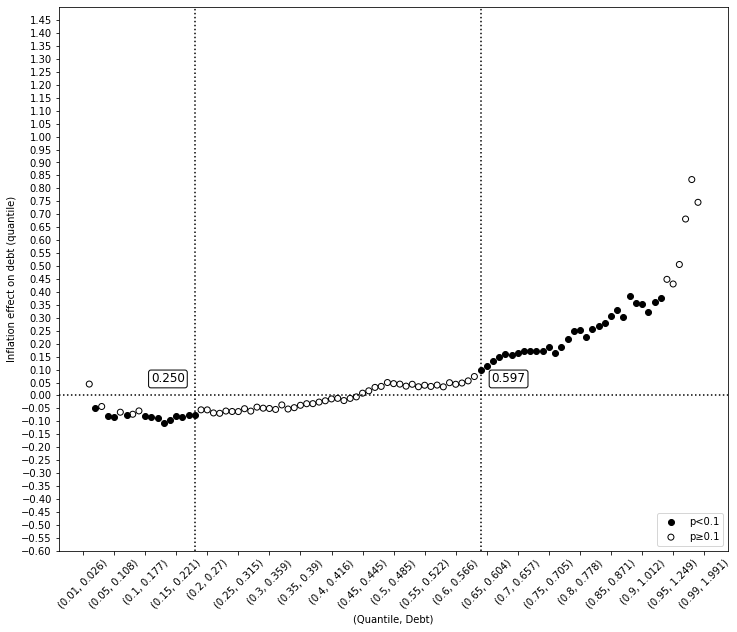

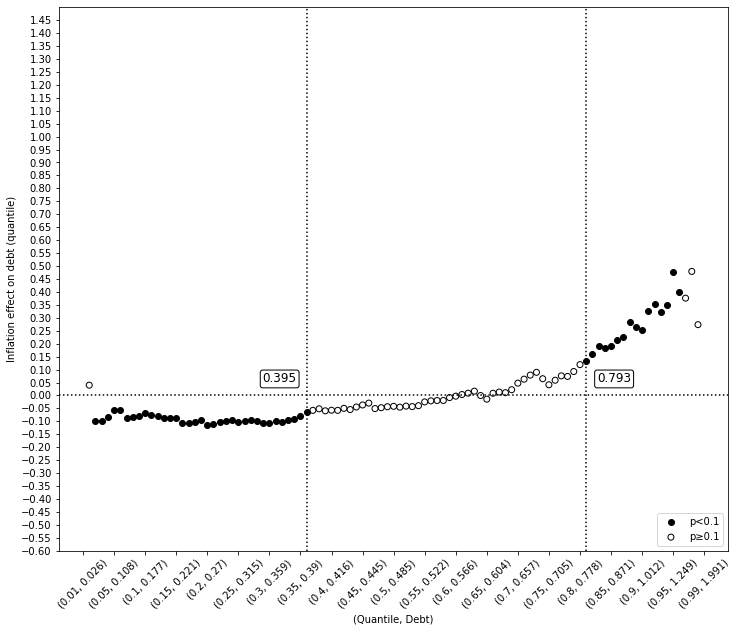

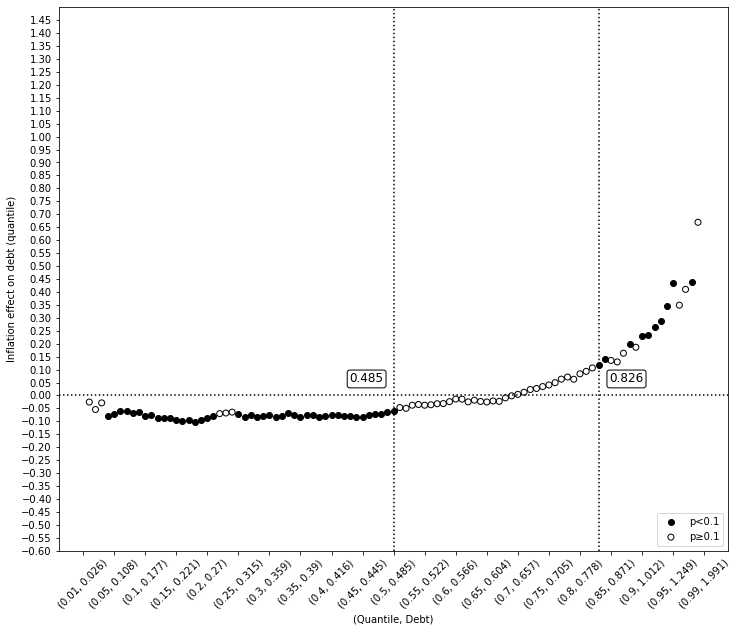

In [831]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    ############################################################################################
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)

    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1', s = significant["pc"])
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label='p≥0.1', s=not_significant["pc"])
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label='p≥0.1')

    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    threshold_v = result_df[(result_df["significative"]==1) & (result_df["Slope"]<0)].iloc[-1]
    threshold = {'Quantile': threshold_v.Quantile, 'Quantile_value': threshold_v.Quantile_value}
    plt.axvline(x=threshold['Quantile'], color='black', linestyle='dotted')


    threshold_v2 = result_df[(result_df["significative"]==1) & (result_df["Slope"]>0)].iloc[0]
    threshold2 = {'Quantile': threshold_v2.Quantile, 'Quantile_value': threshold_v2.Quantile_value}
    plt.axvline(x=threshold2['Quantile'], color='black', linestyle='dotted')


    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Debt)')
    plt.ylabel(f'Inflation effect on debt (quantile)')


    plt.annotate(
        f"{threshold['Quantile_value']:.3f}",
        # f"q {threshold['Quantile']}, Debt: {threshold['Quantile_value']:.3f}",
        xy=(threshold['Quantile'], 0),  # Position of the label
        xytext=(-10, 10),  # Offset for label placement (adjust as needed)
        textcoords='offset points',
        ha='right',  # Horizontal alignment of the label
        va='bottom',  # Vertical alignment of the label
        color='black',  # Text color
        fontsize=12,  # Text font size
        bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white')  # Label background
        )

    plt.annotate(
        f"{threshold2['Quantile_value']:.3f}",
        # f"q {threshold['Quantile']}, Debt: {threshold['Quantile_value']:.3f}",
        xy=(threshold2['Quantile'], 0),  # Position of the label
        xytext=(45, 10),  # Offset for label placement (adjust as needed)
        textcoords='offset points',
        ha='right',  # Horizontal alignment of the label
        va='bottom',  # Vertical alignment of the label
        color='black',  # Text color
        fontsize=12,  # Text font size
        bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white')  # Label background
        )


    plt.legend(scatterpoints=1, loc='lower right')

    ############################################################################################
    ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    ymax, ymin = 1.5, -0.6
    # ymax, ymin = 0.7, -0.2
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,3)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    # plt.legend()
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: depreciación

### Paramétros

In [832]:
DEPENDIENTE   =  "DTC" 
INDEPENDIENTE =  "DH_PI"

os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [833]:
dftc = dfr[dfr.DTC!=0]
# dftc = dfr.copy()

### Estimación (tablas)

In [834]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + WGI_GOV_IND + DEMOCRACY'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slopeb': [result.params["PI"]],
            "p-valueb": [result.pvalues["PI"]],
            'Slope': [result.params[INDEPENDIENTE]],
            "p-value": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


  0%|          | 0/99 [00:00<?, ?it/s]

 69%|██████▊   | 68/99 [00:06<00:02, 14.95it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 99/99 [00:09<00:00,  9.97it/s]
<ipython-input-834-d4125859e6d7>:44: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)
  2%|▏         | 2/99 [00:00<00:11,  8.77it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 99/99 [00:13<00:00,  7.56it/s]
<ipython-input-834-d4125859e6d7>:44: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' cu

### Gráficas

In [835]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

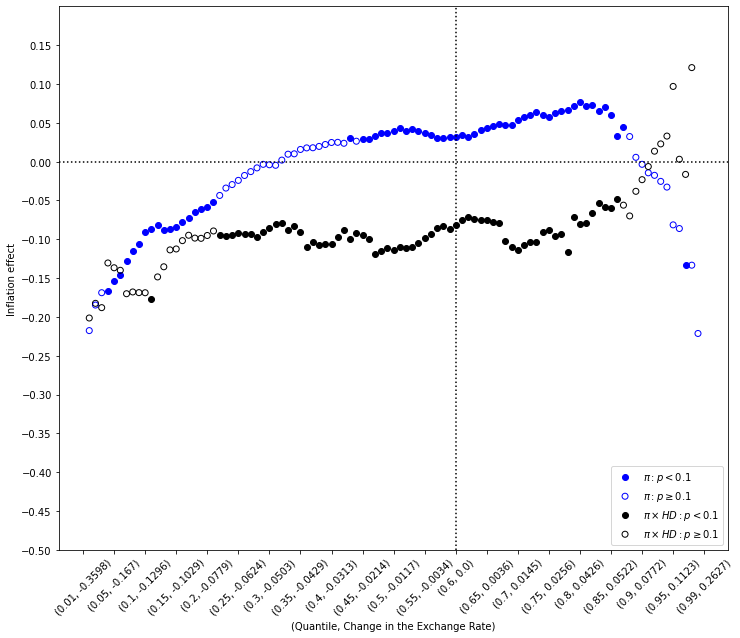

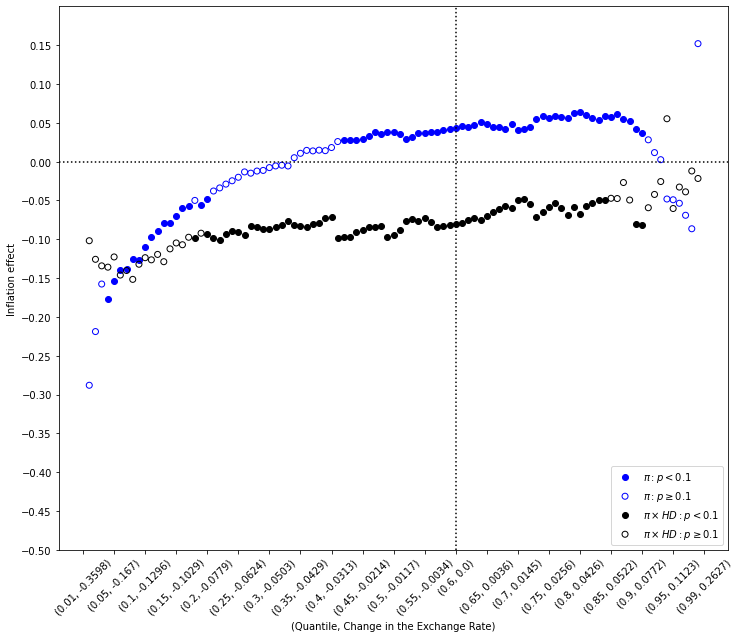

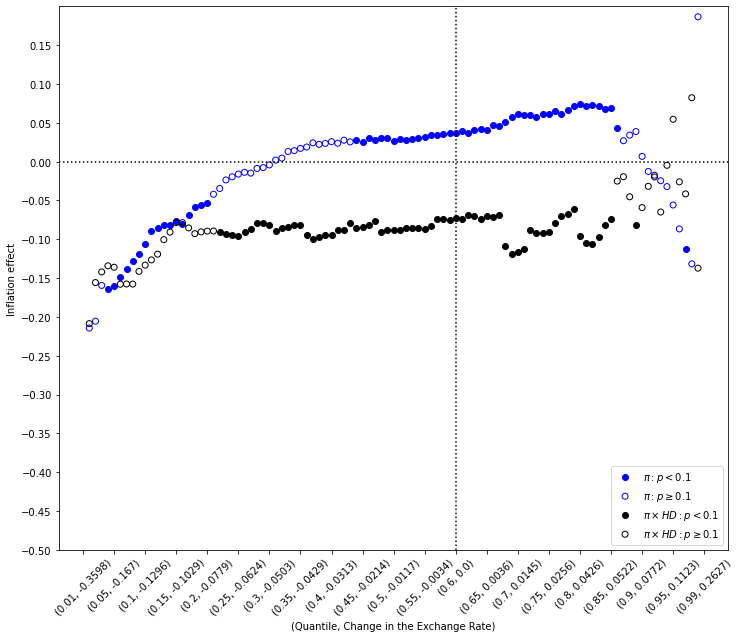

In [836]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$\pi: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$\pi: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=quantil_0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Change in the Exchange Rate)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    ymax, ymin = 0.2, -0.5
    # ymax, ymin = 0.007, -0.002
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower right')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: crecimiento

### Paramétros

In [837]:
DEPENDIENTE   =  "GDPG"
INDEPENDIENTE =  "DH_PI"
os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [838]:
dftc = dfr.copy()

### Estimación (tablas)

In [839]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'GDPG  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'GDPG   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'GDPG   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + + ER_DEP_l1 + ER_DEP_VOL_l1 + WGI_GOV_IND + DEMOCRACY'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slopeb': [result.params["PI"]],
            "p-valueb": [result.pvalues["PI"]],
            'Slope': [result.params[INDEPENDIENTE]],
            "p-value": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


100%|██████████| 99/99 [00:08<00:00, 12.11it/s]
<ipython-input-839-a952312bdd96>:44: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)
  4%|▍         | 4/99 [00:00<00:15,  6.21it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 99/99 [00:15<00:00,  6.49it/s]
<ipython-input-839-a952312bdd96>:44: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)
  5%|▌         | 5/99 [00:01<00:24,  3.86it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum 

### Gráficas

In [840]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

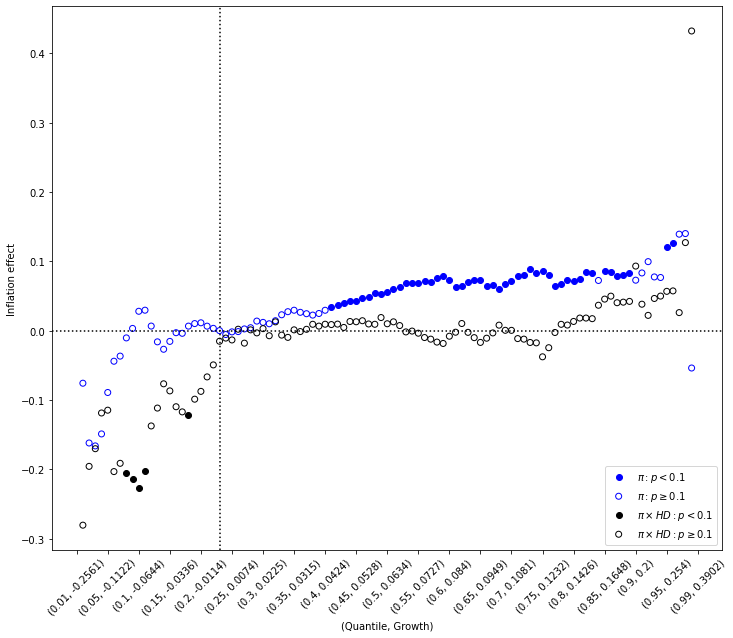

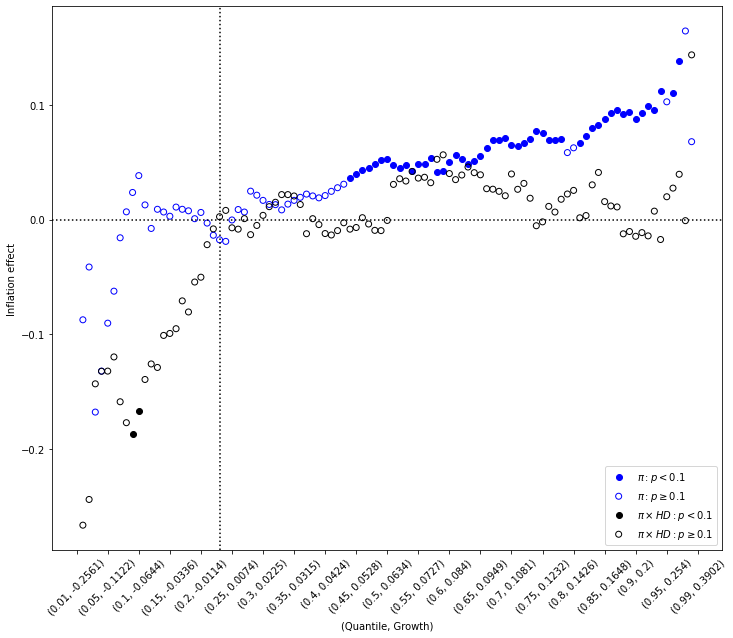

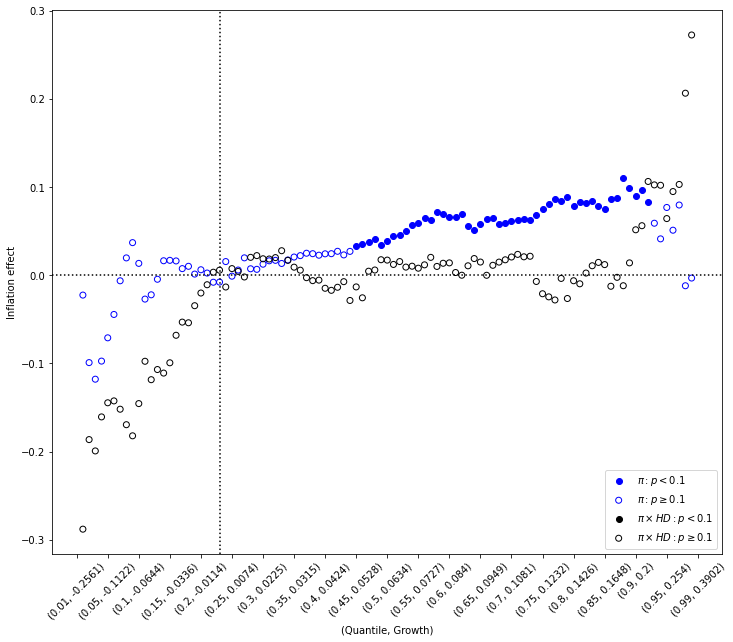

In [841]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$\pi: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$\pi: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=quantil_0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Growth)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # # ymax, ymin = 0.2, -0.5
    # # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower right')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: deuda pública sector no financiero

### Paramétros

In [842]:
DEPENDIENTE   =  "PNFS_NFS"
INDEPENDIENTE =  "DH_PI"
os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [843]:
dftc = dfr.copy()

### Estimación (tablas)

In [844]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + + ER_DEP_l1 + ER_DEP_VOL_l1 + WGI_GOV_IND + DEMOCRACY'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slopeb': [result.params["PI"]],
            "p-valueb": [result.pvalues["PI"]],
            'Slope': [result.params[INDEPENDIENTE]],
            "p-value": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


  7%|▋         | 7/99 [00:00<00:04, 22.08it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
  9%|▉         | 9/99 [00:00<00:07, 12.65it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 33%|███▎      | 33/99 [00:01<00:02, 23.01it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 99/99 [00:04<00:00, 22.69it/s]
<ipython-input-844-6063da0a4192>:44: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currentl

### Gráficas

In [845]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

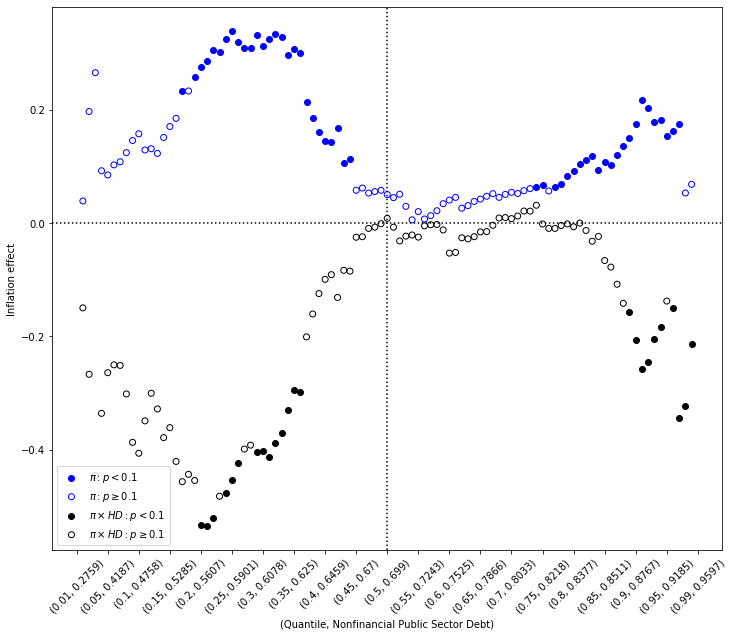

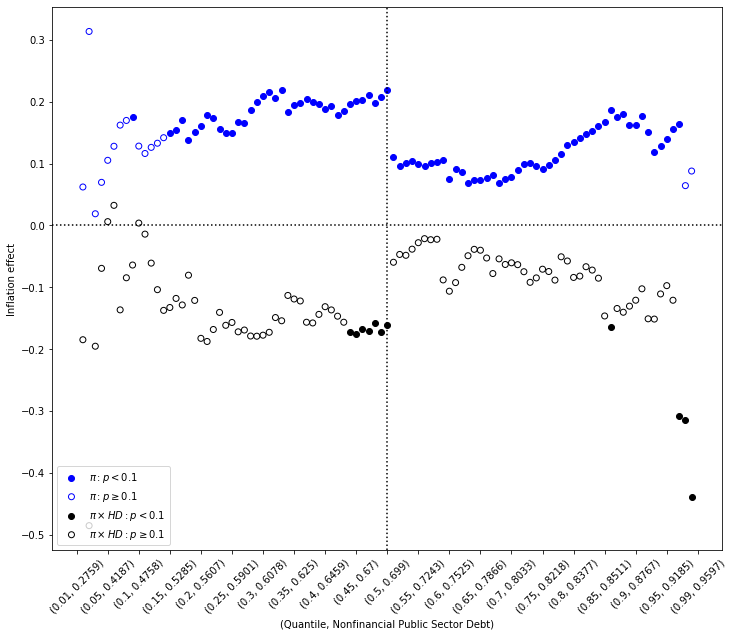

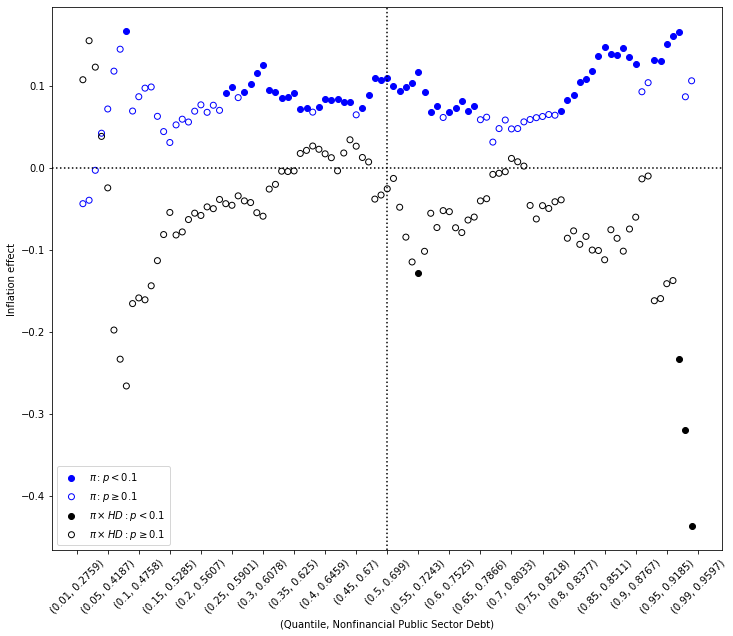

In [846]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$\pi: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$\pi: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    # quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=0.5, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Nonfinancial Public Sector Debt)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # # ymax, ymin = 0.2, -0.5
    # # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower left')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()